In [33]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
# from w207_util import *

random.seed(1234)   
np.random.seed(1234)


In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [3]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3446)


In [26]:

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)

print(init_df.head())

features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

init_df.head()
print(init_df.columns)


y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_validate = np.array(X_validate).reshape((X_validate.shape[0],X_test.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


   lag1_mean_0  lag1_mean_1  lag1_mean_2  lag1_mean_3  lag1_mean_4  \
0     0.165685    -0.852441     0.305529     0.069311    -0.820157   
1    -1.280358    -3.529726     1.199699    -1.149790     0.738967   
2     1.830922    -1.242559     0.019590    -0.955141     4.069830   
3     0.726474    -0.013534     3.577241    -1.806816     0.604612   
4    -0.338823     0.202537    -0.062122    -1.623981    -0.346947   

   lag1_mean_5  lag1_mean_6  lag1_mean_7  lag1_mean_8  lag1_mean_9  ...  \
0     0.671192    -0.889876     0.491933    -0.284130     0.031775  ...   
1    -4.185435    -1.864589    -0.710929     2.279327     0.201870  ...   
2    -8.934466     0.863457     1.437240    -1.496749     0.993456  ...   
3    -0.489957     0.936905    -2.145070    -0.171676    -0.505224  ...   
4    -0.717592    -1.123954    -1.435684     0.115600    -1.780939  ...   

   freq_669_12  freq_679_12  freq_689_12  freq_699_12  freq_709_12  \
0     0.010112     0.002127     0.010123     0.004699     

In [38]:
def train_model(train_dataset, validate_dataset, x_train,
                save_to, epoch = 2, num_of_conv_layer=1, 
                conv_layer_1_filters=32, conv_layer_2_filters=64, conv_layer_3_filters=128,
                num_of_dense_layer=0, 
                dense_layer_1_unit=1024, dense_layer_2_unit=512, dense_layer_3_unit=256,
                patience=10, epoch_denominator=10.):
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
    print("epoch:",epoch,"; num_of_conv_layer:",num_of_conv_layer)
    print("conv_layer_1_filters:",conv_layer_1_filters,"; conv_layer_2_filters:",conv_layer_2_filters)
    print("conv_layer_3_filters:",conv_layer_3_filters,"; num_of_dense_layer:",num_of_dense_layer)
    print("dense_layer_1_unit:",dense_layer_1_unit,"; dense_layer_2_unit:",dense_layer_2_unit)
    print("dense_layer_3_unit:",dense_layer_3_unit,"; patience:",patience)
    print("epoch_denominator:",epoch_denominator)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential()
        
        model.add(tf.keras.layers.Conv1D(
            filters=conv_layer_1_filters,                
            kernel_size=3,
            strides=1,
            padding='same',
            data_format='channels_last',
            name='conv_1',
            activation='relu'))
        
        model.add(tf.keras.layers.MaxPool1D(
            pool_size=2,
            name='pool_1'))
        
        if (num_of_conv_layer >= 2):
            # add second convolutional layer
            model.add(tf.keras.layers.Conv1D(
                filters=conv_layer_2_filters,
                kernel_size=3,
                strides=1,
                padding='same',
                name='conv_2',
                activation='relu'))

            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2, 
                name='pool_2')
            )
            
        if (num_of_conv_layer >= 3):
            # add 3rd convolutional layer
            model.add(tf.keras.layers.Conv1D(
                filters=conv_layer_3_filters,
                kernel_size=3,
                strides=1,
                padding='same',
                name='conv_3',
                activation='relu'))

            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2, 
                name='pool_3')
            )

        model.add(Flatten()) 
        
        # Add Dense layer
        if (num_of_dense_layer >= 1):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_1_unit,
                name='fc_1', 
                activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))
        
        if (num_of_dense_layer >= 2):
            model.add(tf.keras.layers.Dense(
            units=dense_layer_2_unit,
            name='fc_2', 
            activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))
        
        if (num_of_dense_layer >= 3):
            model.add(tf.keras.layers.Dense(
            units=dense_layer_3_unit,
            name='fc_3', 
            activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, x_train.shape[1], 1))
        model.summary()
        tf.keras.utils.plot_model(model)

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
            
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / epoch_denominator))
            
        model.compile(optimizer=opt_adam,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

        
    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])
        
    return model,history


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
epoch: 40 ; num_of_conv_layer: 1
conv_layer_1_filters: 32 ; conv_layer_2_filters: 64
conv_layer_3_filters: 128 ; num_of_dense_layer: 0
dense_layer_1_unit: 1024 ; dense_layer_2_unit: 512
dense_layer_3_unit: 256 ; patience: 10
epoch_denominator: 10.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 55104)             0         
_________________________________________________________________
dense (Dense)                (Non

2022-07-11 22:32:54.420905: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



Epoch 1/40
749/752 [============================>.] - ETA: 0s - loss: 38.3329 - accuracy: 0.3460 - precision: 0.3476 - recall: 0.3341

2022-07-11 22:33:03.250001: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



752/752 [==============================] - 11s 11ms/step - loss: 38.2225 - accuracy: 0.3462 - precision: 0.3479 - recall: 0.3341 - val_loss: 1.8156 - val_accuracy: 0.4049 - val_precision: 0.4761 - val_recall: 0.2176
Epoch 2/40
752/752 [==============================] - 7s 9ms/step - loss: 1.3674 - accuracy: 0.5020 - precision: 0.5905 - recall: 0.2058 - val_loss: 1.8239 - val_accuracy: 0.4163 - val_precision: 0.4670 - val_recall: 0.1954
Epoch 3/40
752/752 [==============================] - 7s 9ms/step - loss: 1.2937 - accuracy: 0.5176 - precision: 0.6271 - recall: 0.2207 - val_loss: 1.5079 - val_accuracy: 0.4410 - val_precision: 0.5423 - val_recall: 0.2287
Epoch 4/40
752/752 [==============================] - 7s 9ms/step - loss: 1.2708 - accuracy: 0.5248 - precision: 0.6324 - recall: 0.2454 - val_loss: 1.4931 - val_accuracy: 0.4844 - val_precision: 0.5590 - val_recall: 0.2417
Epoch 5/40
752/752 [==============================] - 7s 9ms/step - loss: 1.2822 - accuracy: 0.5304 - precision:

752/752 [==============================] - 7s 9ms/step - loss: 0.6224 - accuracy: 0.7609 - precision: 0.8249 - recall: 0.6812 - val_loss: 1.0340 - val_accuracy: 0.6637 - val_precision: 0.7108 - val_recall: 0.5891
Epoch 38/40
752/752 [==============================] - 7s 9ms/step - loss: 0.6161 - accuracy: 0.7641 - precision: 0.8262 - recall: 0.6858 - val_loss: 1.0347 - val_accuracy: 0.6642 - val_precision: 0.7119 - val_recall: 0.5923
Epoch 39/40
752/752 [==============================] - 7s 9ms/step - loss: 0.6114 - accuracy: 0.7666 - precision: 0.8277 - recall: 0.6880 - val_loss: 1.0369 - val_accuracy: 0.6667 - val_precision: 0.7110 - val_recall: 0.5921
Epoch 40/40
752/752 [==============================] - 7s 9ms/step - loss: 0.6070 - accuracy: 0.7685 - precision: 0.8290 - recall: 0.6918 - val_loss: 1.0454 - val_accuracy: 0.6647 - val_precision: 0.7101 - val_recall: 0.5937


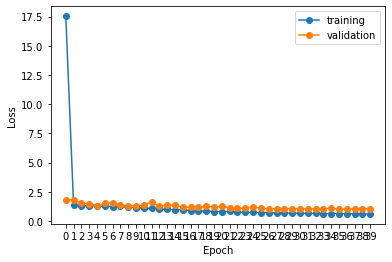

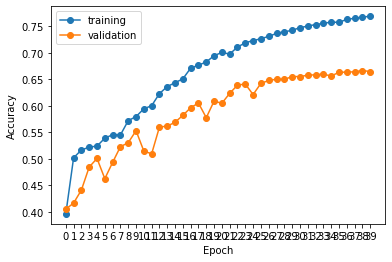

2022-07-11 22:37:34.529743: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



251/251 [==============================] - 2s 6ms/step - loss: 1.0862 - accuracy: 0.6570 - precision: 0.7068 - recall: 0.5906

Test Acc. 65.70%


In [39]:

model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
epoch: 40 ; num_of_conv_layer: 2
conv_layer_1_filters: 32 ; conv_layer_2_filters: 64
conv_layer_3_filters: 128 ; num_of_dense_layer: 0
dense_layer_1_unit: 1024 ; dense_layer_2_unit: 512
dense_layer_3_unit: 256 ; patience: 10
epoch_denominator: 10.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (Non

2022-07-11 22:42:59.485818: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



Epoch 1/40
749/752 [============================>.] - ETA: 0s - loss: 9.4270 - accuracy: 0.3265 - precision: 0.3271 - recall: 0.1122

2022-07-11 22:43:08.912326: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



752/752 [==============================] - 12s 12ms/step - loss: 9.3939 - accuracy: 0.3267 - precision: 0.3273 - recall: 0.1120 - val_loss: 1.3248 - val_accuracy: 0.4053 - val_precision: 0.4777 - val_recall: 0.0307
Epoch 2/40
752/752 [==============================] - 7s 9ms/step - loss: 1.2686 - accuracy: 0.4523 - precision: 0.6059 - recall: 0.0921 - val_loss: 1.2974 - val_accuracy: 0.4782 - val_precision: 0.5831 - val_recall: 0.0876
Epoch 3/40
752/752 [==============================] - 7s 9ms/step - loss: 1.1487 - accuracy: 0.5300 - precision: 0.6936 - recall: 0.2015 - val_loss: 1.1971 - val_accuracy: 0.5354 - val_precision: 0.6497 - val_recall: 0.2572
Epoch 4/40
752/752 [==============================] - 7s 9ms/step - loss: 1.0443 - accuracy: 0.5874 - precision: 0.7423 - recall: 0.3430 - val_loss: 1.1149 - val_accuracy: 0.5623 - val_precision: 0.6867 - val_recall: 0.3435
Epoch 5/40
752/752 [==============================] - 7s 9ms/step - loss: 0.9227 - accuracy: 0.6431 - precision: 

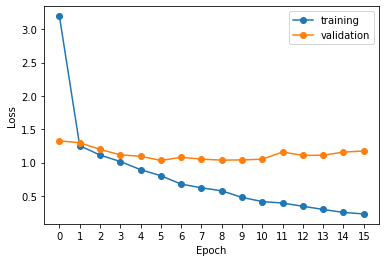

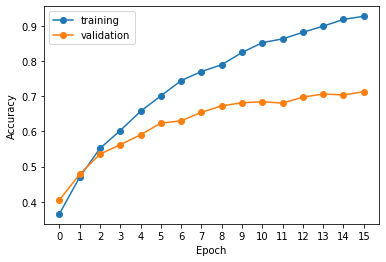

2022-07-11 22:45:03.735080: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



251/251 [==============================] - 2s 6ms/step - loss: 1.2219 - accuracy: 0.7219 - precision: 0.7446 - recall: 0.6932

Test Acc. 72.19%


In [40]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                            num_of_conv_layer=2)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
epoch: 40 ; num_of_conv_layer: 3
conv_layer_1_filters: 32 ; conv_layer_2_filters: 64
conv_layer_3_filters: 128 ; num_of_dense_layer: 0
dense_layer_1_unit: 1024 ; dense_layer_2_unit: 512
dense_layer_3_unit: 256 ; patience: 10
epoch_denominator: 10.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (Non

2022-07-11 22:45:34.187900: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



Epoch 1/40
750/752 [============================>.] - ETA: 0s - loss: 6.0651 - accuracy: 0.2972 - precision: 0.3112 - recall: 0.0645

2022-07-11 22:45:44.475842: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



752/752 [==============================] - 13s 13ms/step - loss: 6.0502 - accuracy: 0.2972 - precision: 0.3113 - recall: 0.0644 - val_loss: 1.3669 - val_accuracy: 0.3196 - val_precision: 0.3864 - val_recall: 0.0085
Epoch 2/40
752/752 [==============================] - 8s 10ms/step - loss: 1.3591 - accuracy: 0.3430 - precision: 0.4403 - recall: 0.0205 - val_loss: 1.3191 - val_accuracy: 0.3766 - val_precision: 0.5389 - val_recall: 0.0260
Epoch 3/40
752/752 [==============================] - 8s 11ms/step - loss: 1.2939 - accuracy: 0.4003 - precision: 0.5641 - recall: 0.0625 - val_loss: 1.2681 - val_accuracy: 0.4263 - val_precision: 0.5829 - val_recall: 0.1311
Epoch 4/40
752/752 [==============================] - 8s 10ms/step - loss: 1.2326 - accuracy: 0.4428 - precision: 0.6420 - recall: 0.1389 - val_loss: 1.2044 - val_accuracy: 0.4722 - val_precision: 0.6516 - val_recall: 0.1713
Epoch 5/40
752/752 [==============================] - 8s 10ms/step - loss: 1.1395 - accuracy: 0.5031 - precisi

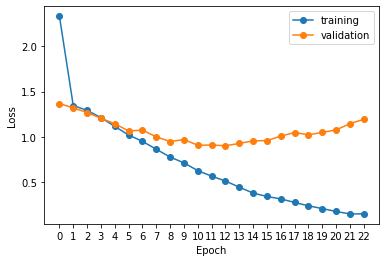

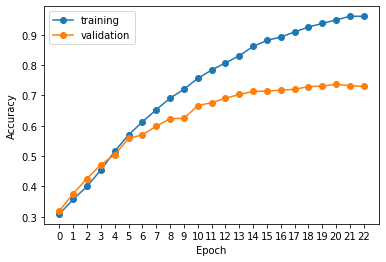

2022-07-11 22:48:48.448736: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



251/251 [==============================] - 2s 6ms/step - loss: 1.2359 - accuracy: 0.7387 - precision: 0.7531 - recall: 0.7236

Test Acc. 73.87%


In [41]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                            num_of_conv_layer=3)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
epoch: 40 ; num_of_conv_layer: 3
conv_layer_1_filters: 32 ; conv_layer_2_filters: 64
conv_layer_3_filters: 128 ; num_of_dense_layer: 1
dense_layer_1_unit: 1024 ; dense_layer_2_unit: 512
dense_layer_3_unit: 256 ; patience: 10
epoch_denominator: 10.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (Non

2022-07-11 22:49:02.248642: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



Epoch 1/40
752/752 [==============================] - ETA: 0s - loss: 20.4857 - accuracy: 0.2622 - precision: 0.2273 - recall: 0.0335

2022-07-11 22:49:23.294018: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



752/752 [==============================] - 24s 26ms/step - loss: 20.4652 - accuracy: 0.2622 - precision: 0.2274 - recall: 0.0335 - val_loss: 1.3737 - val_accuracy: 0.2902 - val_precision: 0.5758 - val_recall: 0.0024
Epoch 2/40
752/752 [==============================] - 18s 24ms/step - loss: 1.3851 - accuracy: 0.2873 - precision: 0.4009 - recall: 0.0038 - val_loss: 1.4098 - val_accuracy: 0.2846 - val_precision: 0.3466 - val_recall: 0.0185
Epoch 3/40
752/752 [==============================] - 18s 24ms/step - loss: 1.3763 - accuracy: 0.3132 - precision: 0.5137 - recall: 0.0168 - val_loss: 1.3887 - val_accuracy: 0.2939 - val_precision: 0.3933 - val_recall: 0.0248
Epoch 4/40
752/752 [==============================] - 18s 24ms/step - loss: 1.3645 - accuracy: 0.3067 - precision: 0.5494 - recall: 0.0162 - val_loss: 1.3712 - val_accuracy: 0.3156 - val_precision: 0.4401 - val_recall: 0.0225
Epoch 5/40
752/752 [==============================] - 18s 24ms/step - loss: 1.3493 - accuracy: 0.3193 - pr

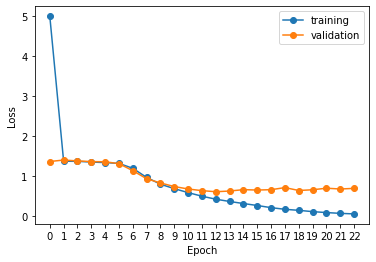

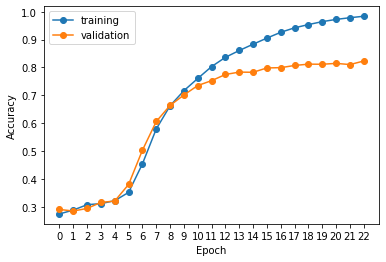

2022-07-11 22:56:15.822268: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



251/251 [==============================] - 2s 7ms/step - loss: 0.7528 - accuracy: 0.8208 - precision: 0.8305 - recall: 0.8115

Test Acc. 82.08%


In [42]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                            num_of_conv_layer=3, num_of_dense_layer=1)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
epoch: 40 ; num_of_conv_layer: 3
conv_layer_1_filters: 32 ; conv_layer_2_filters: 64
conv_layer_3_filters: 128 ; num_of_dense_layer: 2
dense_layer_1_unit: 1024 ; dense_layer_2_unit: 512
dense_layer_3_unit: 256 ; patience: 10
epoch_denominator: 10.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (Non

2022-07-11 22:56:35.858047: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



Epoch 1/40
750/752 [============================>.] - ETA: 0s - loss: 12.9104 - accuracy: 0.2642 - precision: 0.2964 - recall: 0.0423

2022-07-11 22:56:56.889904: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



752/752 [==============================] - 24s 27ms/step - loss: 12.8734 - accuracy: 0.2642 - precision: 0.2964 - recall: 0.0422 - val_loss: 1.3814 - val_accuracy: 0.2602 - val_precision: 0.4167 - val_recall: 0.0012
Epoch 2/40
752/752 [==============================] - 19s 25ms/step - loss: 1.3825 - accuracy: 0.2774 - precision: 0.4273 - recall: 0.0046 - val_loss: 1.3846 - val_accuracy: 0.2798 - val_precision: 0.3712 - val_recall: 0.0122
Epoch 3/40
752/752 [==============================] - 19s 25ms/step - loss: 1.3833 - accuracy: 0.2905 - precision: 0.3997 - recall: 0.0074 - val_loss: 1.3715 - val_accuracy: 0.2996 - val_precision: 0.4944 - val_recall: 0.0055
Epoch 4/40
752/752 [==============================] - 19s 25ms/step - loss: 1.3659 - accuracy: 0.3059 - precision: 0.5095 - recall: 0.0128 - val_loss: 1.3723 - val_accuracy: 0.3067 - val_precision: 0.4455 - val_recall: 0.0056
Epoch 5/40
752/752 [==============================] - 19s 25ms/step - loss: 1.3699 - accuracy: 0.3039 - pr

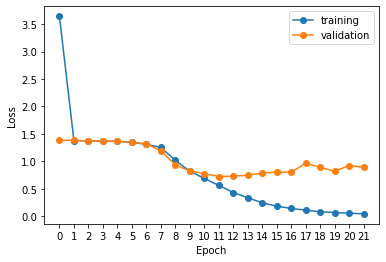

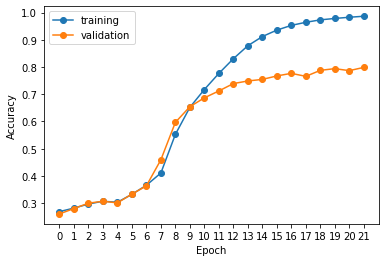

2022-07-11 23:03:38.492131: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



251/251 [==============================] - 2s 7ms/step - loss: 0.9198 - accuracy: 0.7995 - precision: 0.8062 - recall: 0.7950

Test Acc. 79.95%


In [43]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                            num_of_conv_layer=3, num_of_dense_layer=2)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
epoch: 40 ; num_of_conv_layer: 3
conv_layer_1_filters: 32 ; conv_layer_2_filters: 64
conv_layer_3_filters: 128 ; num_of_dense_layer: 3
dense_layer_1_unit: 1024 ; dense_layer_2_unit: 512
dense_layer_3_unit: 256 ; patience: 10
epoch_denominator: 10.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (Non

2022-07-11 23:04:08.728233: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



Epoch 1/40
750/752 [============================>.] - ETA: 0s - loss: 12.7085 - accuracy: 0.2531 - precision: 0.2420 - recall: 0.0355

2022-07-11 23:04:29.902250: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



752/752 [==============================] - 24s 27ms/step - loss: 12.6724 - accuracy: 0.2531 - precision: 0.2420 - recall: 0.0354 - val_loss: 1.3855 - val_accuracy: 0.2758 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
752/752 [==============================] - 19s 25ms/step - loss: 1.3874 - accuracy: 0.2597 - precision: 0.1981 - recall: 3.5317e-04 - val_loss: 1.3826 - val_accuracy: 0.2592 - val_precision: 0.5556 - val_recall: 6.2391e-04
Epoch 3/40
752/752 [==============================] - 19s 25ms/step - loss: 1.3861 - accuracy: 0.2595 - precision: 0.3773 - recall: 0.0010 - val_loss: 1.3750 - val_accuracy: 0.2925 - val_precision: 0.3500 - val_recall: 8.7347e-04
Epoch 4/40
752/752 [==============================] - 19s 25ms/step - loss: 1.3816 - accuracy: 0.2740 - precision: 0.4721 - recall: 0.0033 - val_loss: 1.3748 - val_accuracy: 0.2967 - val_precision: 0.4493 - val_recall: 0.0039
Epoch 5/40
752/752 [==============================] - 19s 25ms/step - loss: 1.3798 - a

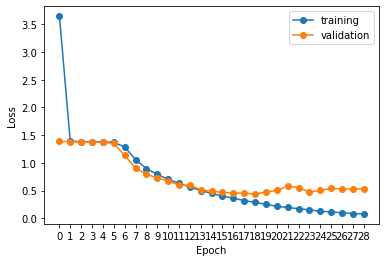

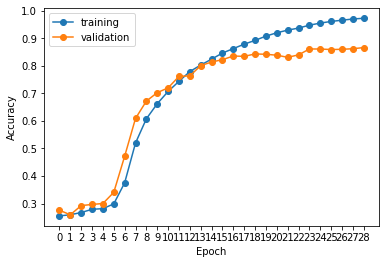

2022-07-11 23:13:27.404896: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_UINT8
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3445
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}



251/251 [==============================] - 2s 7ms/step - loss: 0.5393 - accuracy: 0.8709 - precision: 0.8754 - recall: 0.8659

Test Acc. 87.09%


In [44]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                            num_of_conv_layer=3, num_of_dense_layer=3)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [ ]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                            num_of_conv_layer=3, num_of_dense_layer=2,
                            conv_layer_1_filters=64, conv_layer_2_filters=128, conv_layer_3_filters=256)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [ ]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                            num_of_conv_layer=3, num_of_dense_layer=2,
                            conv_layer_1_filters=128, conv_layer_2_filters=256, conv_layer_3_filters=512)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [ ]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40,  
                            num_of_conv_layer=3, num_of_dense_layer=2,
                            conv_layer_1_filters=256, conv_layer_2_filters=128, conv_layer_3_filters=64)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [ ]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 60,  
                            num_of_conv_layer=3, num_of_dense_layer=2,
                            conv_layer_1_filters=256, conv_layer_2_filters=128, conv_layer_3_filters=64)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [ ]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40,  
                            num_of_conv_layer=3, num_of_dense_layer=2,
                            conv_layer_1_filters=256, conv_layer_2_filters=128, conv_layer_3_filters=64)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [ ]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40,  
                            num_of_conv_layer=3, num_of_dense_layer=2,
                            conv_layer_1_filters=64, conv_layer_2_filters=128, conv_layer_3_filters=256)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [ ]:
model,history = train_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 60,  
                            num_of_conv_layer=3, num_of_dense_layer=2,
                            conv_layer_1_filters=64, conv_layer_2_filters=128, conv_layer_3_filters=256,
                            epoch_denominator=15)

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

In [ ]:
# train/validate/test
# 1 Conv1D(32): 
#  loss: 0.6173 - accuracy: 0.7622 - val_loss: 0.9949 - val_accuracy: 0.6636
#  test accuracy: 66.82%

# 2 Conv1D(32/64): 
#  loss: 0.1461 - accuracy: 0.9651 - val_loss: 1.1545 - val_accuracy: 0.7219
#  test accuracy: 73.15%

# 3 Conv1D(32/64/128): 
#  loss: 0.0403 - accuracy: 0.9979 - val_loss: 1.2396 - val_accuracy: 0.7446
#  test accuracy: 75.50%

# 3 Conv1D(32/64/128) + 1 Dense(1024): 
#  loss: 0.0315 - accuracy: 0.9937 - val_loss: 0.9972 - val_accuracy: 0.7610
#  test accuracy: 76.61%

# 3 Conv1D(32/64/128) + 2 Dense(1024/512): 
#  loss: 0.0312 - accuracy: 0.9906 - val_loss: 1.0195 - val_accuracy: 0.8076
#  test accuracy: 81.52%

# 3 Conv1D(32/64/128) + 3 Dense(1024/512/256): 
#  loss: 0.0296 - accuracy: 0.9916 - val_loss: 1.6523 - val_accuracy: 0.7166
#  test accuracy: 73.19%

# 3 Conv1D(64/128/256) + 2 Dense(1024/512): 
#  loss: 0.0777 - accuracy: 0.9754 - val_loss: 0.2747 - val_accuracy: 0.9119
#  test accuracy: 90.66%

# 3 Conv1D(128/256/512) + 2 Dense(1024/512): 
#  loss: 0.2128 - accuracy: 0.9249 - val_loss: 0.5036 - val_accuracy: 0.8475
#  test accuracy: 84.7% 

# 3 Conv1D(256/128/64) + 2 Dense(1024/512): 
#  loss: 0.0913 - accuracy: 0.9688 - val_loss: 0.2776 - val_accuracy: 0.9100
#  test accuracy: 90.94% <- can give it more epoch since it runs till the end.

# 3 Conv1D(256/128/64) + 2 Dense(1024/512), 60 epoch: 
#  loss: 0.1041 - accuracy: 0.9667 - val_loss: 0.5814 - val_accuracy: 0.8435
#  test accuracy: 84.69%

# 3 Conv1D(256/128/64) + 2 Dense(1024/512): 
#  loss: 0.0406 - accuracy: 0.9884 - val_loss: 0.8349 - val_accuracy: 0.8192
#  test accuracy: 82.92% <- why is different from before when it was 90.94%??

# 3 Conv1D(64/128/256) + 2 Dense(1024/512): 
#  loss: 0.0158 - accuracy: 0.9962 - val_loss: 0.6036 - val_accuracy: 0.8790
#  test accuracy: 87.66% (early stopped 29/40)

# 3 Conv1D(64/128/256) + 2 Dense(1024/512), 60 epoch, 15 epoch_denominator: 
#  loss: 0.0396 - accuracy: 0.9868 - val_loss: 0.6766 - val_accuracy: 0.8535
#  test accuracy: 85.24%

